In [3]:
cd "C:\Users\lukas\Desktop\frankfurt-environment-dashboard"

C:\Users\lukas\Desktop\frankfurt-environment-dashboard


In [4]:
import ee
ee.Initialize(project='ee-ffm069')
print("Earth Engine läuft!")

Earth Engine läuft!


In [5]:
import geemap
import pandas as pd
import datetime as dt

from src.regions import frankfurt_bbox
roi = frankfurt_bbox()

print("ROI geladen:", roi)

ROI geladen: ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              8.45,
              50.25
            ],
            [
              8.45,
              50.0
            ],
            [
              8.9,
              50.0
            ],
            [
              8.9,
              50.25
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


In [21]:
# Sentinel-5P TROPOMI NO₂-Kollektion laden
collection = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    .select("tropospheric_NO2_column_number_density")
    .filterBounds(roi)
)

# Zeitraum der letzten 14 Tage
end = ee.Date(dt.date.today().strftime("%Y-%m-%d"))
start = end.advance(-60, "day")

subset = collection.filterDate(start, end)

print("Anzahl täglicher NO₂-Bilder im Zeitraum:", subset.size().getInfo())


Anzahl täglicher NO₂-Bilder im Zeitraum: 580


In [9]:
band = "tropospheric_NO2_column_number_density"

percentiles = no2_7d.reduceRegion(
    reducer=ee.Reducer.percentile([5, 95]),
    geometry=roi,
    scale=7000,
    maxPixels=1e9
)

p5 = percentiles.get(f"{band}_p5").getInfo()
p95 = percentiles.get(f"{band}_p95").getInfo()
p5, p95

(8.629853952053295e-05, 0.00019340280475357188)

In [14]:
# 7-Tage Mittelwert (haben wir schon berechnet)
no2_7d = subset.mean().clip(roi)

# Karte mit besserem Basemap & Transparenz
Map = geemap.Map(center=[50.1109, 8.6821], zoom=11)

# Beschriftete Basemap (Straßen, Stadtnamen etc.)
Map.add_basemap("OpenStreetMap")  # oder "HYBRID", "CartoDB.Positron" etc.

viz_dyn = {
    "min": p5,   # falls du schon die Perzentile berechnet hast
    "max": p95,  # sonst kannst du wieder feste Werte nehmen
    "palette": ["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"],
}

# NO2-Layer halb transparent
Map.addLayer(no2_7d, viz_dyn, "NO₂ 7-Tage Mittelwert", True, 0.6)

# Frankfurt-Markierung (zur Orientierung)
Map.add_marker(
    location=[50.1109, 8.6821],
    tooltip="Frankfurt am Main"
)

# ROI-Rand (optional)
Map.addLayer(roi, {}, "ROI", False)

Map

Map(center=[50.1109, 8.6821], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprig…

In [17]:
import pandas as pd

def ee_to_pandas(fc):
    """Konvertiert eine Earth Engine FeatureCollection in ein Pandas DataFrame."""
    features = fc.getInfo()["features"]
    data = [f["properties"] for f in features]
    return pd.DataFrame(data)

In [22]:
def daily_mean_series(ic, band, region, start, end, scale=7000):
    def _daily(img):
        stat = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=scale,
            maxPixels=1e9
        )
        return ee.Feature(None, {
            "date": img.date().format("YYYY-MM-dd"),
            "value": stat.get(band),
        })

    feats = (
        ic.filterDate(start, end)
          .map(_daily)
          .filter(ee.Filter.notNull(["value"]))
    )

    df = ee_to_pandas(feats)
    df["date"] = pd.to_datetime(df["date"])
    return df.sort_values("date")


band_name = "tropospheric_NO2_column_number_density"
df_no2 = daily_mean_series(subset, band_name, roi, start, end)
df_no2.tail()


,date,value
21,2025-10-21,0.000050
22,2025-10-27,0.000058
23,2025-10-29,0.000076
24,2025-10-30,0.000060
25,2025-11-04,0.000122


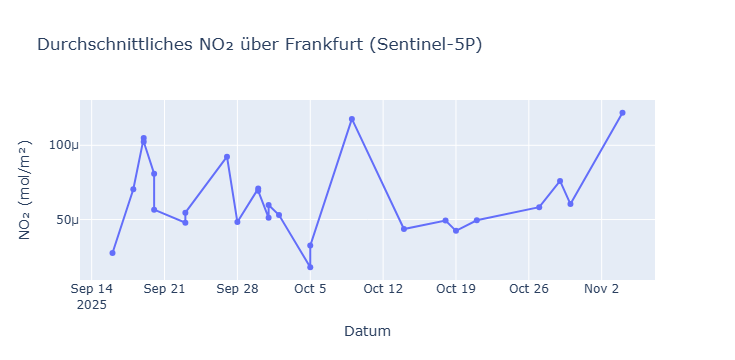

In [23]:
import plotly.express as px

fig = px.line(
    df_no2,
    x="date",
    y="value",
    title="Durchschnittliches NO₂ über Frankfurt (Sentinel-5P)",
    labels={"date": "Datum", "value": "NO₂ (mol/m²)"}
)
fig.update_traces(mode="lines+markers")
fig.show()
